In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math
import os
import pandas as pd
from typing import Tuple
import inference


In [5]:
# importing the given ground truth training and test datasets

Lorenz_63_train = np.load(r'Traindata/lorenz63_on0.05_train.npy')
Lorenz_63_test = np.load(r'Testdata/lorenz63_test.npy')

Lorenz_96_train = np.load(r'Traindata/lorenz96_on0.05_train.npy')
Lorenz_96_test = np.load(r'Testdata/lorenz96_test.npy')


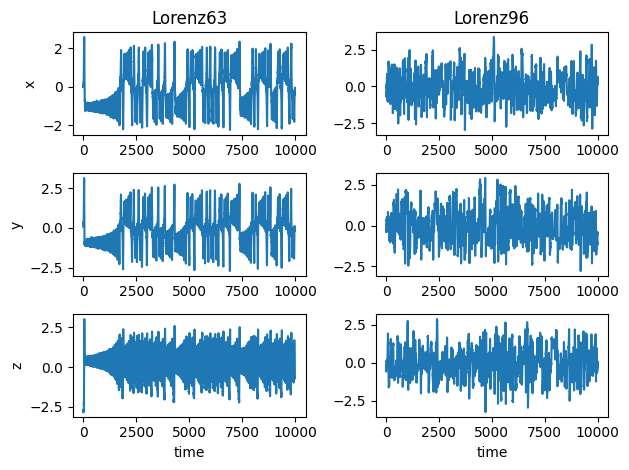

In [6]:
# for better overview, plot training time-series

fig, axs = plt.subplots(3,2)

axs[0,0].plot(Lorenz_63_train[0:10000,0])
axs[0,0].set_ylabel('x')
axs[0,0].set_title('Lorenz63')

axs[1,0].plot(Lorenz_63_train[0:10000,1])
axs[1,0].set_ylabel('y')

axs[2,0].plot(Lorenz_63_train[0:10000,2])
axs[2,0].set_ylabel('z')
axs[2,0].set_xlabel('time')

axs[0,1].plot(Lorenz_96_train[0:10000,0])
#axs[0,1].set_ylabel('x')
axs[0,1].set_title('Lorenz96')

axs[1,1].plot(Lorenz_96_train[0:10000,1])
#axs[1,1].set_ylabel('y')

axs[2,1].plot(Lorenz_96_train[0:10000,2])
#axs[2,1].set_ylabel('z')
axs[2,1].set_xlabel('time')

plt.tight_layout()


In [7]:
# implementation of performance measure

import psd

def loss(x_gen, x_true):
    return psd.power_spectrum_error_per_dim(x_gen, x_true)

def measure(x_true):
    T = np.shape(x_true)[0] # length of test time-series
    x0 = np.random.uniform(-10, 10, 3) # choose random initial condition (x,y,z)
    x_gen = model(x0=x0, time=T)



In [14]:
from dataset import TransformerDataset
from transformer_timeseries import TimeSeriesTransformer as tst 
import utils
from positional_encoder import PositionalEncoder as pe 
import psd
import utils
import torch
import inference
import numpy as np
import dataset as ds


In [18]:
# Hyperparams
#test_size = 0.1
batch_size = 128
target_col_name = 'x' # first of three features
timestamp_col = "t"

# Define input variables 
exogenous_vars = ['y', 'z'] # should contain strings. 
#Each string must correspond to a column name
input_variables = [target_col_name] + exogenous_vars
target_idx = 0 # index position of target in batched trg_y
window_size = 6
step_size=10

input_size = len(input_variables)


epochs = 10
forecast_window = 2 # we start with trying 2 values
enc_seq_len = 4 # previous 4 data points


In [19]:
import utils

training_indices = utils.get_indices_entire_sequence(
        data=Lorenz_63_train, 
        window_size=window_size, 
        step_size=step_size
        )

# Making instance of custom dataset class
print(Lorenz_63_train.shape)
training_data = ds.TransformerDataset(
        data=torch.tensor(Lorenz_63_train).float(),
        indices=training_indices,
        enc_seq_len=enc_seq_len,
        dec_seq_len=forecast_window,
        target_seq_len=forecast_window
        )

# Making dataloader
training_dataloader = DataLoader(dataset=training_data, 
                                       batch_size=batch_size, drop_last=True)

batch_first = True
model_63 = tst(
    input_size=len(input_variables),
    dec_seq_len=forecast_window,
    batch_first=batch_first,
    num_predicted_features=3
    )



(100000, 3)
From get_src_trg: data size = torch.Size([100000, 3])


In [21]:
optimizer = torch.optim.Adam(model_63.parameters())

criterion = torch.nn.MSELoss()

Loss = []

# Iterate over all epochs
for epoch in range(epochs):

    # Iterate over all (x,y) pairs in training dataloader
    for i, (src, tgt, tgt_y) in enumerate(training_dataloader):

        # zero the parameter gradients
        optimizer.zero_grad()

        # Generate masks
        tgt_mask = utils.generate_square_subsequent_mask(
            dim1=forecast_window,
            dim2=forecast_window
            )

        src_mask = utils.generate_square_subsequent_mask(
            dim1=forecast_window,
            dim2=enc_seq_len
            )

        # Make forecasts
        print(src.shape,
              tgt.shape,
              src_mask.shape,
              tgt_mask.shape)
        prediction = model_63(src, tgt, src_mask, tgt_mask)

        # Compute and backprop loss
        # print(tgt_y.shape, prediction.shape)    
        loss = criterion(tgt_y, prediction)
        loss_val = loss.detach().numpy()
        Loss.append(loss_val)
        print(epoch, loss_val)

        loss.backward()

        # Take optimizer step
        optimizer.step()

torch.Size([128, 4, 3]) torch.Size([128, 2, 3]) torch.Size([2, 4]) torch.Size([2, 2])
0 1.4058915
torch.Size([128, 4, 3]) torch.Size([128, 2, 3]) torch.Size([2, 4]) torch.Size([2, 2])
0 2.935445
torch.Size([128, 4, 3]) torch.Size([128, 2, 3]) torch.Size([2, 4]) torch.Size([2, 2])
0 2.285062
torch.Size([128, 4, 3]) torch.Size([128, 2, 3]) torch.Size([2, 4]) torch.Size([2, 2])
0 1.1221555
torch.Size([128, 4, 3]) torch.Size([128, 2, 3]) torch.Size([2, 4]) torch.Size([2, 2])
0 1.1658111
torch.Size([128, 4, 3]) torch.Size([128, 2, 3]) torch.Size([2, 4]) torch.Size([2, 2])
0 0.9873803
torch.Size([128, 4, 3]) torch.Size([128, 2, 3]) torch.Size([2, 4]) torch.Size([2, 2])
0 1.4037491
torch.Size([128, 4, 3]) torch.Size([128, 2, 3]) torch.Size([2, 4]) torch.Size([2, 2])
0 1.6470833
torch.Size([128, 4, 3]) torch.Size([128, 2, 3]) torch.Size([2, 4]) torch.Size([2, 2])
0 1.1489774
torch.Size([128, 4, 3]) torch.Size([128, 2, 3]) torch.Size([2, 4]) torch.Size([2, 2])
0 0.8974506
torch.Size([128, 4, 3]

KeyboardInterrupt: 

(0.0, 780.0)

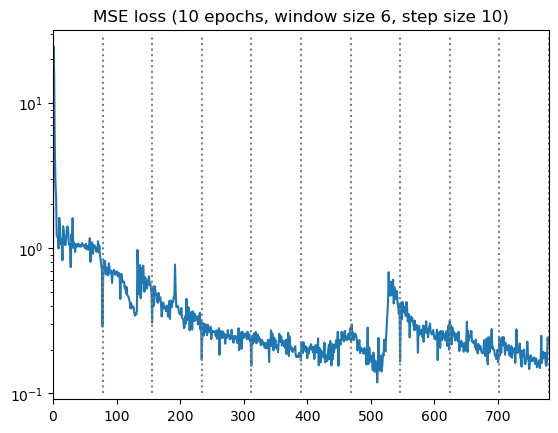

In [24]:
plt.plot(Loss)
plt.yscale('log')
plt.title('MSE loss (10 epochs, window size 6, step size 10)')
plt.vlines([0, 78, 2*78, 3*78, 4*78, 5*78, 6*78, 7*78, 8*78, 9*78, 780], ymin=1e-1, ymax = 30,
           linestyle=':', color='grey')
plt.xlim((0, 780))

In [ ]:
# Hyperparams
batch_size = 128
batch_first = False

window_size = 6
step_size=10

input_size = 3


epochs = 10
forecast_window = 2 # we start with trying 2 values
enc_seq_len = 4 # previous 4 data points


In [26]:
training_indices = utils.get_indices_entire_sequence(
        data=Lorenz_63_train, 
        window_size=window_size, 
        step_size=step_size
        )

# Making instance of custom dataset class
training_data = ds.TransformerDataset(
        data=torch.tensor(Lorenz_63_train).float(),
        indices=training_indices,
        enc_seq_len=enc_seq_len,
        dec_seq_len=forecast_window,
        target_seq_len=forecast_window
        )

# Making dataloader
training_dataloader = DataLoader(dataset=training_data, 
                                       batch_size=batch_size, drop_last=True)

model_63_2 = tst(
    input_size=input_size,
    dec_seq_len=forecast_window,
    batch_first=batch_first,
    num_predicted_features=input_size
    )



From get_src_trg: data size = torch.Size([100000, 3])


In [28]:
optimizer = torch.optim.Adam(model_63_2.parameters())

criterion = torch.nn.MSELoss()

Loss_2 = []

# Iterate over all epochs
for epoch in range(epochs):

    # Iterate over all (x,y) pairs in training dataloader
    for i, (src, tgt, tgt_y) in enumerate(training_dataloader):

        # zero the parameter gradients
        optimizer.zero_grad()

        # Generate masks
        tgt_mask = utils.generate_square_subsequent_mask(
            dim1=forecast_window,
            dim2=forecast_window
            )

        src_mask = utils.generate_square_subsequent_mask(
            dim1=forecast_window,
            dim2=enc_seq_len
            )

        # Make forecasts
        prediction = model_63_2(src, tgt, src_mask, tgt_mask)

        # Compute and backprop loss
        loss = criterion(tgt_y, prediction)
        loss_val = loss.detach().numpy()
        Loss_2.append(loss_val)
        print(epoch, loss_val)

        loss.backward()

        # Take optimizer step
        optimizer.step()

0 1.7114253
0 27.913597
0 4.3806615
0 4.7708135
0 3.0999558
0 1.2975692
0 1.377143
0 2.008045
0 1.4973427
0 0.9630885
0 1.2497171
0 1.0196123
0 1.4823087
0 1.5278019
0 1.2365407
0 0.801466
0 1.1351041
0 1.068154
0 1.0225962
0 1.0908374
0 1.1154596
0 1.1898259
0 1.3848734
0 1.3212835
0 1.2465094
0 1.0700822
0 1.1333059
0 0.9602253
0 0.72177315
0 1.2595357
0 1.107435
0 1.5987064
0 0.9890359
0 1.07681
0 0.99403405
0 0.95714873
0 1.0442364
0 1.0026461
0 1.0437412
0 1.0197839
0 1.0952965
0 1.0239884
0 1.0597954
0 1.0453119
0 1.036795
0 1.0715023
0 1.0769179
0 1.0351863
0 1.036331
0 1.0384434
0 1.0357589
0 1.0342461
0 1.0809419
0 0.99449307
0 1.0582185
0 1.0041709
0 1.0086864
0 1.0357276
0 1.1984324
0 0.8236969
0 1.000666
0 1.1130273
0 1.0901808
0 0.934035
0 1.0636858
0 1.0922154
0 1.1002162
0 1.0467938
0 1.0058488
0 1.0113183
0 1.039106
0 1.2008781
0 1.0416955
0 1.1772524
0 1.089794
0 1.1045197
0 1.026826
0 1.0324893
1 1.027201
1 1.0310816
1 1.1028492
1 0.9248988
1 1.1467234
1 1.1956139
1 1

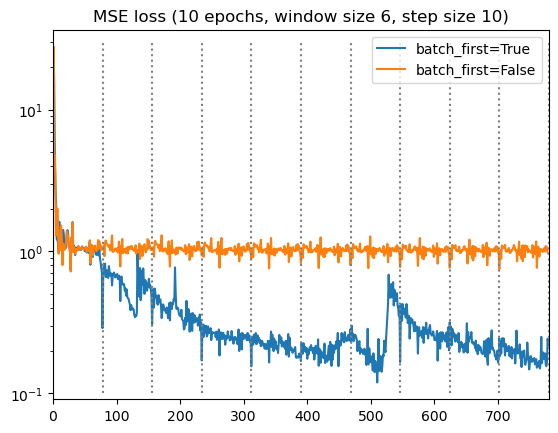

In [31]:
plt.plot(Loss, label='batch_first=True')
plt.plot(Loss_2, label='batch_first=False')
plt.yscale('log')
plt.title('MSE loss (10 epochs, window size 6, step size 10)')
plt.vlines([0, 78, 2*78, 3*78, 4*78, 5*78, 6*78, 7*78, 8*78, 9*78, 780], ymin=1e-1, ymax = 30,
           linestyle=':', color='grey')
plt.xlim((0, 780))
plt.legend()

When repeating the same optimization, with the exact same hyperparameters as before, but with batch_first=False, the training loss does not decrease at all but stays constant at around $MSE=1$.